In [1]:
import cv2
import numpy as np
import os 
import time
import pickle

from IPython.display import clear_output
from PIL import Image, ImageDraw

# My custom library of photoelastic tools
import sys
sys.path.append('/eno/jdfeathe/pepe/')

from pepe.preprocess import crossMask, checkImageType, circularMask, lightCorrectionDiff, rectMask, mergeMasks

from pepe.analysis import initialForceSolve, forceOptimize
from pepe.tracking import houghCircle, convCircle
from pepe.simulate import genSyntheticResponse
from pepe.utils import preserveOrderArgsort
from pepe.auto import forceSolve

import progressbar

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

rootFolder = '/eno/jdfeathe/DATA/SpaceJam/'
dataFolder = '/eno/jdfeathe/DATA/SpaceJam/2022-02-02_Wide/'

In [2]:
# Our radius that we will be identifying particles with
guessRadius = 160

# A particle is about 1cm across
pxPerMeter = 2*guessRadius / .01
# No idea what the actual value for this is
fSigma = 140

# How much to blur the photoelastic channel by
blurKernel = 2

# Parameters of our force solving method
contactPadding = 20
g2MaskPadding = 2
contactMaskRadius = 40
brightfield = False

# Create a mask over the image, that will also be used to detect the boundary
maskXBounds = [430, 760] # Found manually
maskYBounds = [340, 670] # Found manually

# Account for any light gradients in the image
correctionImage = checkImageType(rootFolder + '2022-02-02_Calibration.bmp')
# For light correction, we want two separate images, one vertical and one horizontal
height, width = correctionImage.shape[:2]
verticalMask = np.array([[int(i < maskXBounds[1] and i > maskXBounds[0]) for i in range(width)] for j in range(height)])
horizontalMask = np.transpose([[int(i < maskYBounds[1] and i > maskYBounds[0]) for i in range(height)] for j in range(width)])

correction = lightCorrectionDiff(correctionImage, verticalMask, horizontalMask)

maskArr = crossMask(correctionImage.shape, xlim=np.array(maskXBounds), ylim=np.array(maskYBounds))

# Add in the pegs on the boundary particles
pegCenters = [[20, 550], [20, 650], [990, 540], [990, 650]]
pegRadii = 15

for i in range(len(pegCenters)):
    maskArr = maskArr - circularMask(correctionImage.shape, np.array(pegCenters[i]), pegRadii)
    
maskArr = maskArr > 0


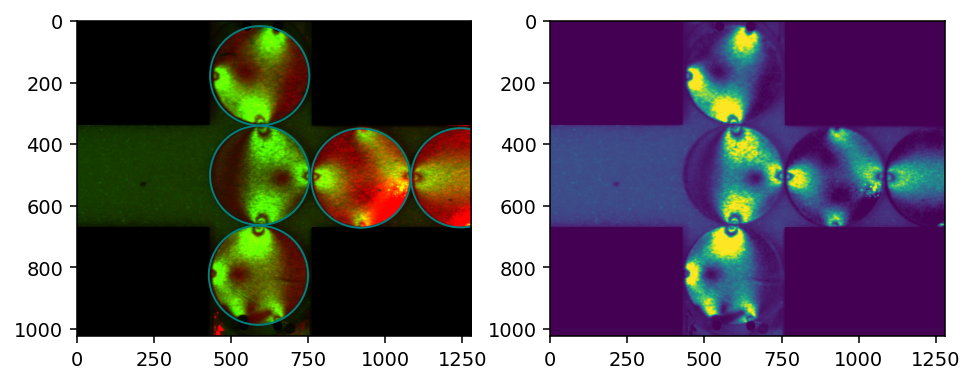

In [3]:
# Make some fake data with several potential wall contacts
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

#image = checkImageType('test_data/Test_2022-01-28.bmp')
image = checkImageType(dataFolder + 'frame0220.bmp')

# g2 to force conversion is calibrated on the scale [0, 1], not [0, 255]
# We also blur the images a little, since they are visibly grainy
photoelasticChannel = cv2.blur(image[:,:,1].astype(np.float64) / 255, (3,3))

centers, radii = convCircle(image[:,:,0] * maskArr[:,:,0], guessRadius)

centers = centers.astype(np.int64)
radii = radii.astype(np.int64)
# Make them all odd
radii += (radii % 2) == 0

ax[0].imshow(maskArr * image)
for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], label='Detected particles', color='teal', fill=False, linewidth=1)
    ax[0].add_artist(c)

ax[1].imshow(photoelasticChannel * maskArr[:,:,0])
plt.show()

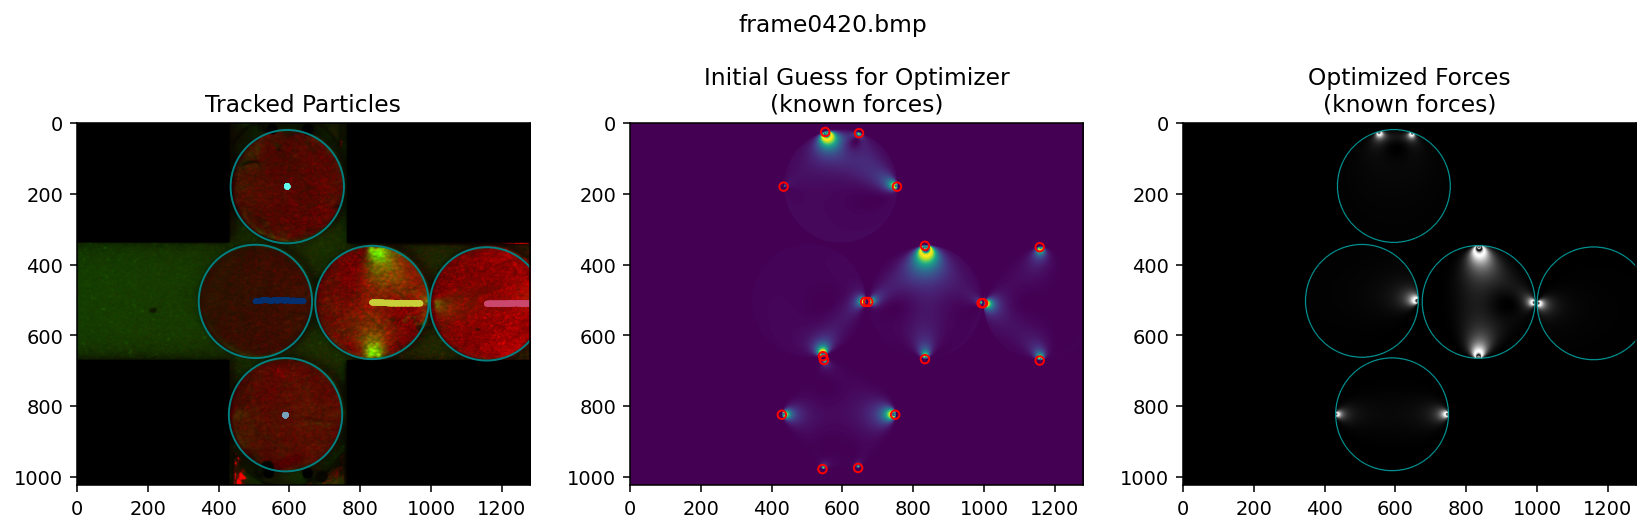

 99% (329 of 330) |#################### | Elapsed Time: 11:16:42 ETA:   0:02:04

Took 124.52s to solve frame:
     Tracking:         1.1s
     Initial guess:    1.33s
     Optimization:     1.11e+02s
     Misc. processes:  11.5s


In [4]:
optimizationKwargs = {"maxEvals": [250, 20], "method": 'nelder',
                     "parametersToFit": [['f', 'a'], ['b', 'a']],
                     "allowRemoveForces": True, "alphaTolerance": /eno/ceobrero.5,
                     "allowAddForces": True, "minForceThreshold": .02}

forceArr, betaArr, alphaArr, centerArr, radiusArr = forceSolve(dataFolder, guessRadius, fSigma, pxPerMeter,
                                                        brightfield, maskImage=maskArr, imageStartIndex=90,
                                                        debug=True, optimizationKwargs=optimizationKwargs, saveMovie=True)

with open('force.pickle', 'wb') as f:
    pickle.dump(forceArr, f)
    
with open('beta.pickle', 'wb') as f:
    pickle.dump(betaArr, f)
    
with open('alpha.pickle', 'wb') as f:
    pickle.dump(alphaArr, f)
    
with open('centers.pickle', 'wb') as f:
    pickle.dump(centerArr, f)
    
with open('radii.pickle', 'wb') as f:
    pickle.dump(radiusArr, f)

In [102]:
def rectangularizeForceArrays(forceArr, alphaArr, betaArr, centerArr, radiusArr):
    rectForceArr = []
    rectBetaArr = []
    rectAlphaArr = []

    # Scalar
    maxNumParticles = np.max([len(betaArr[i]) for i in range(len(betaArr))])
    numTimesteps = len(forceArr)
    # First, make the centers array look nice, which we then use to identify
    # particles
    rectCenterArr = np.zeros((maxNumParticles, numTimesteps, 2))
    rectRadiusArr = np.zeros((maxNumParticles, numTimesteps))
    
    # We have to initialize the first element so that we can then use the
    # preserveOrderSort function to make sure the identities stay
    # consistent
    rectCenterArr[:,0] = list(centerArr[0]) + [[np.nan, np.nan]]*(maxNumParticles - len(centerArr[0]))
    rectRadiusArr[:,0] = list(radiusArr[0]) + [np.nan]*(maxNumParticles - len(centerArr[0]))
    
    particleOrder = np.zeros((numTimesteps, maxNumParticles), dtype=np.int16)
    particleOrder[0] = np.arange(len(particleOrder[0]))
    particleExists = np.zeros((numTimesteps, maxNumParticles), dtype=np.int16)
    
    for i in range(1, numTimesteps):
        particleOrder[i] = preserveOrderArgsort(rectCenterArr[:,i-1][np.isnan(rectCenterArr[:,i-1])[:,0] == False], centerArr[i], padMissingValues=True)
        rectCenterArr[:,i] = [centerArr[i][particleOrder[i,j]] if particleOrder[i,j] is not None else [np.nan, np.nan] for j in range(len(particleOrder[i]))]
        rectRadiusArr[:,i] = [radiusArr[i][particleOrder[i,j]] if particleOrder[i,j] is not None else np.nan for j in range(len(particleOrder[i]))]
        
    # We now have linked the particles from frame to frame, and can
    # rectangularize the other quantities on a particle-by-particle basis
    for i in range(maxNumParticles):
        # The maximum number of forces this particle ever has
        maxNumForces = np.max([len(forceArr[j][particleOrder[j,i]]) for j in range(numTimesteps) if particleOrder[j,i] is not None])
        
        singleParticleForceArr = np.zeros((maxNumForces, numTimesteps))
        singleParticleBetaArr = np.zeros((maxNumForces, numTimesteps))
        singleParticleAlphaArr = np.zeros((maxNumForces, numTimesteps))

        singleParticleForceArr[:,0] = list(forceArr[0][particleOrder[0,i]]) + [np.nan]*(maxNumForces - len(forceArr[0][particleOrder[0,i]]))
        singleParticleBetaArr[:,0] = list(betaArr[0][particleOrder[0,i]]) + [np.nan]*(maxNumForces - len(betaArr[0][particleOrder[0,i]]))
        singleParticleAlphaArr[:,0] = list(alphaArr[0][particleOrder[0,i]]) + [np.nan]*(maxNumForces - len(alphaArr[0][particleOrder[0,i]]))
        
        for j in range(1, numTimesteps):
            particleIndex = particleOrder[j,i]
            order = preserveOrderArgsort(singleParticleBetaArr[:,j-1][np.isnan(singleParticleBetaArr[:,j-1]) == False], betaArr[j][particleIndex], padMissingValues=True)
            order = list(order) + [None]*(maxNumForces - len(order))
            singleParticleForceArr[:,j] = [forceArr[j][particleIndex][order[k]] if order[k] is not None else np.nan for k in range(len(order))]
            singleParticleBetaArr[:,j] = [betaArr[j][particleIndex][order[k]] if order[k] is not None else np.nan for k in range(len(order))]
            singleParticleAlphaArr[:,j] = [alphaArr[j][particleIndex][order[k]] if order[k] is not None else np.nan for k in range(len(order))]

        print(singleParticleBetaArr[:,-1])

        rectForceArr.append(singleParticleForceArr)
        rectAlphaArr.append(singleParticleAlphaArr)
        rectBetaArr.append(singleParticleBetaArr)
        
    return rectForceArr, rectAlphaArr, rectBetaArr, rectCenterArr, rectRadiusArr

rectForceArr, rectAlphaArr, rectBetaArr, rectCenterArr, rectRadiusArr = rectangularizeForceArrays(forceArr, alphaArr, betaArr, centerArr, radiusArr)

[-1.29629630e-05  1.55840374e+00  3.13736375e+00             nan]
[1.56138878        nan        nan]
[ 1.57080506 -1.57079129         nan         nan         nan]
[-2.87330071  2.80507541         nan]
[-1.58205838         nan         nan]


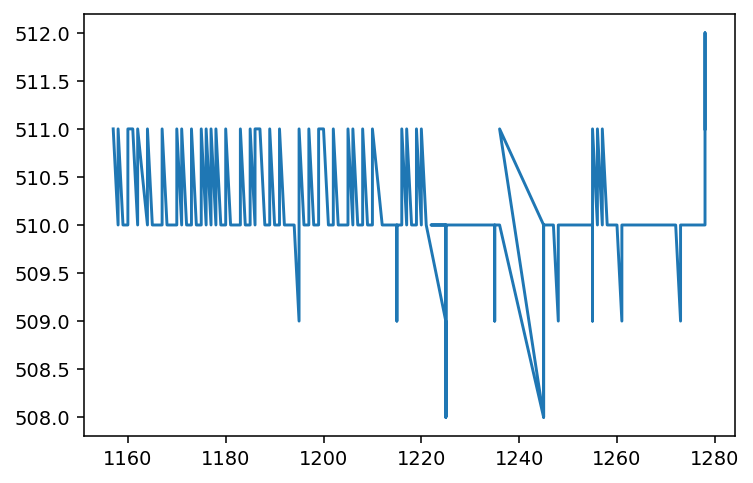

In [100]:
plt.plot(rectCenterArr[4][:,1], rectCenterArr[4][:,0])
plt.show()

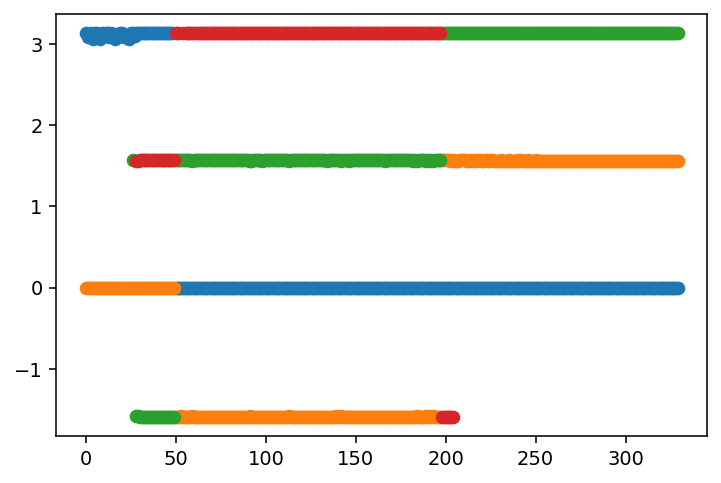

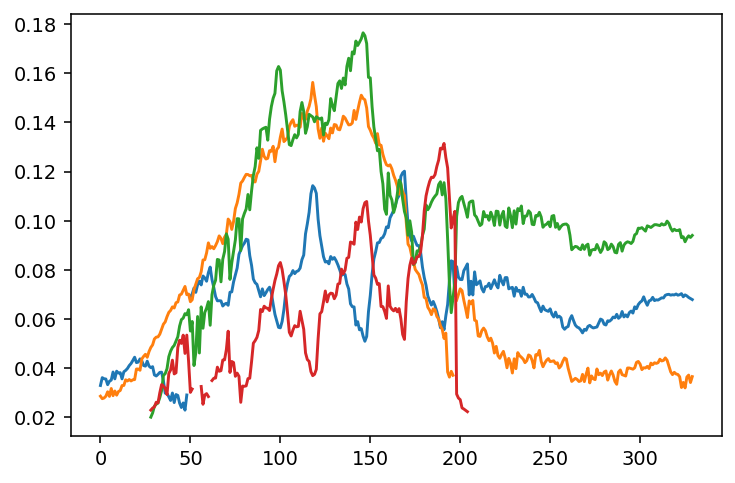

In [94]:
particleIndex = 0
for i in range(len(rectBetaArr[particleIndex])):
    plt.plot(rectBetaArr[particleIndex][i], 'o')
plt.show()

for i in range(len(rectForceArr[particleIndex])):
    plt.plot(rectForceArr[particleIndex][i])
plt.show()